# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import statsmodels.stats.proportion as stprop
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of entries and callbacks by race
print('w:',sum(data.race=='w'),'call:',sum((data.race=='w') & (data.call==1)),'Percentage:',sum((data.race=='w') & (data.call==1))/sum(data.race=='w'))
print('b:',sum(data.race=='b'),'call:',sum((data.race=='b') & (data.call==1)),'Percentage:',sum((data.race=='b') & (data.call==1))/sum(data.race=='b'))

w: 2435 call: 235 Percentage: 0.09650924024640657
b: 2435 call: 157 Percentage: 0.06447638603696099


In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


### 1. Appropriate Test
#### Distribution
The sample in the problem is Bernoulli distribution. <br>
We have two such samples - one for 'w' and the other for 'b'. We can approach the solution in 2 ways - 
1. By running one sample tests on both these samples separately and comparing the means to arrive at the statistical significance.
2. By running two sample test on both the samples and arriving at the statistical significance
Both the approaches can be analyzed using Central Limit Theorem on the samples by drawing multiple samples from the given sample.

### 2. Hypothesis
H<sub>0</sub>: There is no racial discrimination; Mean callback for 'b' = Mean callback for 'w'<br>
H<sub>a</sub>: There is racial discrimination; Mean callback for 'b' <> Mean callback for 'w'<br><br><br>

<div  style="color:red"> *The current solution only considers race factor while analyzing the callbacks and ignores all the others, even though they are valid factors that influence the interview call - like education, experience, honors, etc. The study will be expanded later.</div>

#### Bootstrap Approach
Bootstrap approach draws multiple samples from the available observation sample to construct a normal distribution as per Central Limit Theorem

In [5]:
#Bootstrapping functions:

def draw_bs_samples(data,func,choice_size,samp_size):
    bs_perm_sample = np.empty(samp_size)
    for i in np.arange(samp_size):
        bs_perm_sample[i] = func(np.random.choice(data,choice_size))
        
    return bs_perm_sample

def getNumBins(numObs):
    num_bins = (int((1 + 3.322 * np.log(numObs))/5)+1)*5
    return num_bins

In [6]:
w = data[data.race=='w'].call
b = data[data.race=='b'].call

mean_w = np.mean(w)
mean_b = np.mean(b)

num_iterations = 10000
alpha = 0.05

print('w call mean:',mean_w)
print('b call mean:',mean_b)

w call mean: 0.09650924056768417
b call mean: 0.0644763857126236


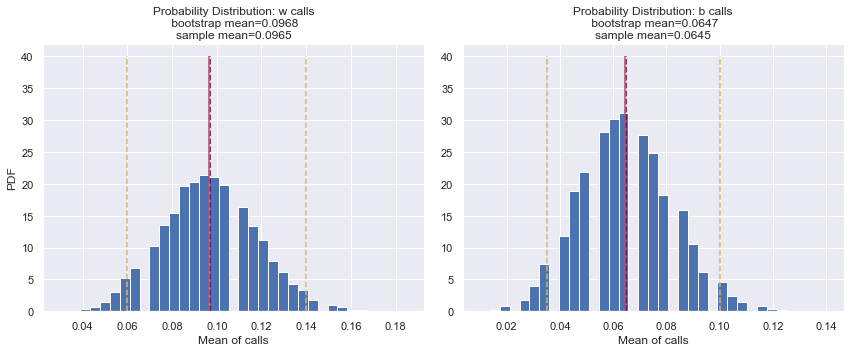

In [7]:
choice_size = 200 # As per the 10% rule of independent sample, the chosen sample size is 200 < 10% of 2435

w_clt_sample = draw_bs_samples(w,np.mean,choice_size,num_iterations)
w_binsize=getNumBins(len(w_clt_sample))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(w_clt_sample,bins=w_binsize,density=1)
plt.vlines(np.mean(w_clt_sample),0,40,colors='indigo',linestyles='dashed')
plt.vlines(np.percentile(w_clt_sample,[2.5,97.5]),0,40,colors='y',linestyles='dashed')
plt.vlines(mean_w,0,40,colors='r')
plt.title('Probability Distribution: w calls\n bootstrap mean='+ str(round(np.mean(w_clt_sample),4))+'\nsample mean='+str(round(mean_w,4)))
plt.xlabel('Mean of calls')
plt.ylabel('PDF')

b_clt_sample = draw_bs_samples(b,np.mean,choice_size,num_iterations)
b_binsize=getNumBins(len(b_clt_sample))

plt.subplot(1,2,2)
plt.hist(b_clt_sample,bins=b_binsize,density=1)
plt.vlines(np.mean(b_clt_sample),0,40,colors='indigo',linestyles='dashed')
plt.vlines(np.percentile(b_clt_sample,[2.5,97.5]),0,40,colors='y',linestyles='dashed')
plt.vlines(mean_b,0,40,colors='r')
plt.title('Probability Distribution: b calls\n bootstrap mean='+ str(round(np.mean(b_clt_sample),4))+'\nsample mean='+str(round(mean_b,4)))
plt.xlabel('Mean of calls')

plt.tight_layout()
plt.show()

In [13]:
# Hypothesis testing
w_moe = st.norm.ppf(0.975)*np.std(w_clt_sample)
w_conf_interval = [np.mean(w_clt_sample)-st.norm.ppf(0.975)*np.std(w_clt_sample), np.mean(w_clt_sample)+st.norm.ppf(0.975)*np.std(w_clt_sample)]
print('Bootstrap approach:')
print('w:')
print('    Margin of Error that whites on an average receive an interview call:',round(w_moe,4))
print('    95% Confidence interval that whites on an average receive an interview call:',np.round(w_conf_interval,4))
print('    95% Confidence interval that of '+str(len(w))+' applications from white people, number that receive an interview call:',np.round(np.multiply(w_conf_interval,len(w))))

b_moe = st.norm.ppf(0.975)*np.std(b_clt_sample)
b_conf_interval = [np.mean(b_clt_sample)-st.norm.ppf(0.975)*np.std(b_clt_sample), np.mean(b_clt_sample)+st.norm.ppf(0.975)*np.std(b_clt_sample)]
print('b:')
print('    Margin of Error that blacks on an average receive an interview call:',round(b_moe,4))
print('    95% Confidence interval that blacks on an average receive an interview call:',np.round(b_conf_interval,4))
print('    95% Confidence interval that of '+str(len(b))+' applications from black people, number that receive an interview call:',np.round(np.multiply(b_conf_interval,len(b))))

# If Null Hypothesis were true, the mean of number of calls for blacks = mean of number of calls for whites.
t, p = st.ttest_ind(w_clt_sample,b_clt_sample)
print('\np-value = ',p)

if p > alpha:
    print('Fail to reject H0: The data is NOT STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w = Mean callback for b')
else:
    print('Reject H0: The data is STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w <> Mean callback for b')


Bootstrap approach:
w:
    Margin of Error that whites on an average receive an interview call: 0.0413
    95% Confidence interval that whites on an average receive an interview call: [0.0555 0.1381]
    95% Confidence interval that of 2435 applications from white people, number that receive an interview call: [135. 336.]
b:
    Margin of Error that blacks on an average receive an interview call: 0.0342
    95% Confidence interval that blacks on an average receive an interview call: [0.0305 0.0989]
    95% Confidence interval that of 2435 applications from black people, number that receive an interview call: [ 74. 241.]

p-value =  0.0
Reject H0: The data is STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w <> Mean callback for b


In [9]:
np.multiply(w_conf_interval,2435)

array([135.22259391, 336.22262625])

##### Conclusion
As analyzed above using bootstrap approach and Central Limit Thoerem, we reject H<sub>0</sub> concluding that the data suggests interview calls are racially biased - whites tend to get more calls than blacks do.

#### Frequentist Approach
Frequentist approach deduces the statistic using the observation sample

In [10]:
prop_w_calls = sum(w==1)/len(w)
prop_b_calls = sum(b==1)/len(b)
print('Proportion of whites getting interview calls: ',prop_w_calls)
print('Proportion of blacks getting interview calls: ',prop_b_calls)

Proportion of whites getting interview calls:  0.09650924024640657
Proportion of blacks getting interview calls:  0.06447638603696099


As the numbers above suggest there's a clear difference in the proportion of calls between whites and blacks<br><br>

The same hypothesis applies in the frequentist analysis<br>

H<sub>0</sub>: There is no racial discrimination; Mean callback for 'b' = Mean callback for 'w'<br>
H<sub>a</sub>: There is racial discrimination; Mean callback for 'b' <> Mean callback for 'w'

In [11]:
#Theoretical:
#Null Hypothesis assumes that prop_b_calls = prop_w_calls. Based on the assumption, 

z_b = (prop_b_calls-prop_w_calls)/np.sqrt(prop_w_calls*(1-prop_w_calls)/len(b))

print('z value for b:', z_b)
p_b = st.norm.cdf(z_b)
print('p value for b:', p_b)
if p_b > alpha:
    print('Fail to reject H0: The data is NOT STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w = Mean callback for b')
else:
    print('Reject H0: The data is STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w <> Mean callback for b')

#Through Python statsmodels:
z_b_st, p_b_st = stprop.proportions_ztest(sum(b==1),len(b),prop_w_calls)
print('\nz value for b through statsmodels:', z_b_st)
print('p value for b through statsmodels:', p_b_st)
if p_b_st > alpha:
    print('Fail to reject H0: The data is NOT STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w = Mean callback for b')
else:
    print('Reject H0: The data is STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w <> Mean callback for b')


z value for b: -5.353019358042918
p value for b: 4.32492956813822e-08
Reject H0: The data is STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w <> Mean callback for b

z value for b through statsmodels: -6.436020213191311
p value for b through statsmodels: 1.2264670785805746e-10
Reject H0: The data is STATISTICALLY SIGNIFICANTLY DIFFERENT between interview calls for blacks and whites; Mean callback for w <> Mean callback for b


C:\Users\km4147\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.
C:\Users\km4147\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


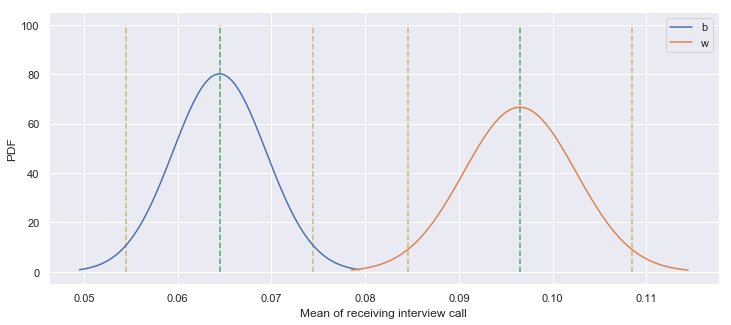

In [12]:
plt.figure(figsize=(12,5))

mu_b = prop_b_calls
sigma_b = np.sqrt(prop_b_calls*(1-prop_b_calls)/len(b))

mu_w = prop_w_calls
sigma_w = np.sqrt(prop_w_calls*(1-prop_w_calls)/len(w))

x_b = np.linspace(mu_b - 3*sigma_b, mu_b + 3*sigma_b, 100)
plt.plot(x_b,mlab.normpdf(x_b, mu_b, sigma_b),label='b')
plt.vlines(mu_b,0,100,colors='g',linestyles='dashed')
plt.vlines([mu_b-2*sigma_b, mu_b+2*sigma_b],0,100,colors='y',linestyles='dashed')

x_w = np.linspace(mu_w - 3*sigma_w, mu_w + 3*sigma_w, 100)
plt.plot(x_w,mlab.normpdf(x_w, mu_w, sigma_w),label='w')
plt.vlines(mu_w,0,100,colors='g',linestyles='dashed')
plt.vlines([mu_w-2*sigma_w, mu_w+2*sigma_w],0,100,colors='y',linestyles='dashed')

plt.xlabel('Mean of receiving interview call')
plt.ylabel('PDF')
plt.legend()
plt.show()

As evidenced above, there's clearly no statistical significance between the percentage of white people receiving the calls and that of black people receiving interview calls - considering only race as a factor and ignoring all the others.

## Conclusion
While the analysis shows that race is a significant factor in calling for interview, there are many other factors like education, experience, availability, location, etc. that may negate the conclusion we drew considering only race. The analysis can be amended by considering all these important factors and painting a complete picture of racial discrimination